# Multitaper Windows - Class Interface

The SHWindow class provides an interface to compute window functions that concentrate energy spatially into a given region and in frequency to low degrees. This allows to generate a quality coupling matrix, that couples degrees over a range that is as little as possible.

Say, for example, that we would like to determine the spectrum of the bathymetry of the Earth and compare it with the land spectrum. To this end, we generate window functions for the land and the oceans. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pyshtools.shclasses import SHCoeffs, SHGrid, SHWindow


pyshtools 3.3-beta -- Tools for working with spherical harmonics.


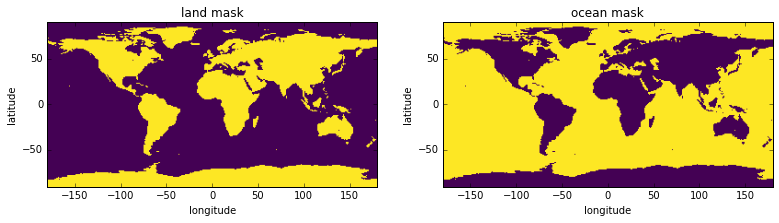

In [15]:
# read earth topography example data
infile = '../ExampleDataFiles/topo.dat.gz'
topo = np.loadtxt(infile)
nlat, nlon = topo.shape
lmax = nlat / 2 - 1
land_mask = (topo > 0)
ocean_mask = ~land_mask

# plot
fig, (col1, col2) = plt.subplots(1, 2, figsize= (13, 5))
col1.imshow(land_mask, extent=(-180, 180, -90, 90), cmap='viridis')
col1.set(xlabel='longitude', ylabel='latitude', title='land mask')
col2.imshow(ocean_mask, extent=(-180, 180, -90, 90), cmap='viridis')
col2.set(xlabel='longitude', ylabel='latitude', title='ocean mask');

## optimally concentrated window functions

SHTOOLS provides a method to solve the so called *concentration problem*, i.e. to find a window that is optimally concentrated in a given region with band-limited coefficient energy below a certain *lmax*. The smaller the region, the larger should be *lmax* to allow for a good concentration. Because the oceans span a larger region, *lmax_ocean* can therefore be smaller than *lmax_land* while still getting well concentrated windows. The *concentration* value that is indicated above the plots, shows the energy of the window that lies within the original region. The final spectrum is a (possibly weighted) average of the individual spectral measurements.

ocean windows
Asymmetric window with 10 tapers


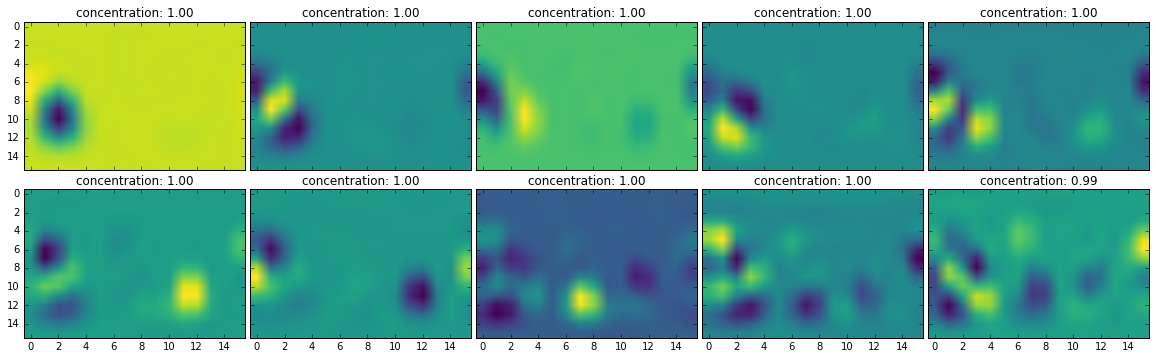

land windows
Asymmetric window with 10 tapers


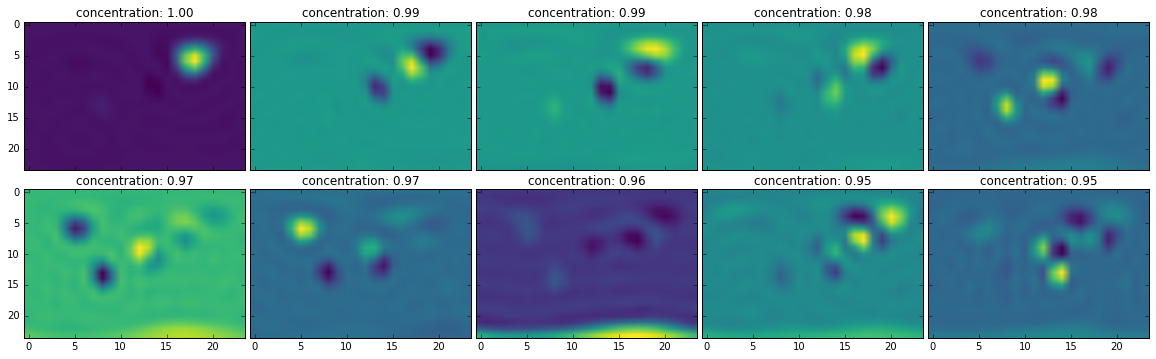

In [3]:
lmax_ocean = 7
lmax_land = 11
nwins = 10
ocean_windows = SHWindow.from_mask(lmax_ocean, nwins, ocean_mask, sampling=2)
land_windows = SHWindow.from_mask(lmax_land, nwins, land_mask, sampling=2)

print 'ocean windows'
ocean_windows.info()
ocean_windows.plot(nwins, show=True)
print 'land windows'
land_windows.info()
land_windows.plot(nwins, show=True)

The following plot shows how power of the land windows extents to larger degrees than the power of the ocean windows, that are constraint with a lower *lmax*. Of course, the ocean will allow for higher quality measurements at lower degrees.

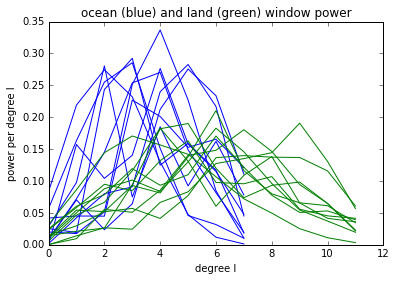

In [14]:
winpower_land = land_windows.get_powerperdegree()
winpower_ocean = ocean_windows.get_powerperdegree()

fig, ax = plt.subplots(1, 1)
for itaper in range(nwins):
    ax.plot(winpower_ocean[itaper], c='blue')
    
for itaper in range(nwins):
    ax.plot(winpower_land[itaper], c='green')

ax.set(xlabel='degree l', ylabel='power per degree l',
       title='ocean (blue) and land (green) window power');

## the coupling matrix

The coupling matrix reflects the different quality of the land and ocean spectra. The higher degree part (towards the bottom right) corresponds to a simple convolution. It becomes asymptotically symmetric around the diagonal. The land windows couple degrees over a wider range and therefore decrease the spectral resolution that can be achieved.

The second effect is the asymmetric part of the coupling matrix towards low degrees: Low input degrees map to higher output degrees. E.g. input degree 0 maps strongest to around degree 3 in the ocean case and to around degree 6 in the land case. This is the consequence that we can not estimate the global mean or very large wavelength structures from subregions that are much smaller. Low degree energy maps therefore to the lowest window degrees, where they increase the overall power.

Smoothing and bias need to be considered when comparing spectra that have been obtained with two different windows.

ocean coupling matrix


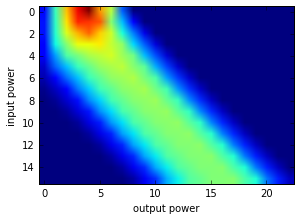

land coupling matrix


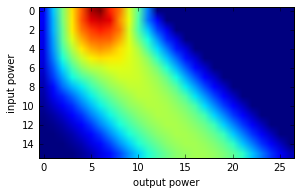

In [20]:
print 'ocean coupling matrix'
ocean_windows.plot_couplingmatrix(15, nwins)

print 'land coupling matrix'
land_windows.plot_couplingmatrix(15, nwins)

The coupling matrix describes the expected coupling between coefficients that are independent (stationary and isotropic models). Obviously, the toography of the Earth is not stationary and isotropic and a simple prediction about a regional measurement can therefore not be made. For example, if a non-stationary model is zero in the windowed region, the local spectrum will also be zero and not the global spectrum distorted by the coupling matrix.

Nevertheless, the coupling matrix is useful, because it allows us to differentiate between the effect of the window and the effect due to a particular region, that can have a particular power spectrum as well in the case of a non-stationary model.

## regional spectral estimates